In [115]:
# Importing the libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from itertools import combinations
import scipy.stats as ss

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# I. Importing and Cleaning Data

In [116]:
salary_df = pd.read_csv("ds_salaries.csv")
salary_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [117]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [118]:
salary_df.select_dtypes(exclude='object').describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [119]:
salary_df.select_dtypes(include='object').describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


In [120]:
for feature in salary_df.columns:
    if len(salary_df[feature].value_counts())<10:
        print(salary_df[feature].value_counts())

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64
remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64
company_size
M    3153
L     454
S     148
Name: count, dtype: int64


In [121]:
## group employee_residence and company_location into five regions 

continents_df = pd.read_csv("continents2.csv")

In [122]:
continents_df.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [123]:
continents_df=continents_df[['alpha-2','region']]

In [124]:
continents_df.dropna(inplace=True)

In [125]:
continents_df['region'].value_counts()

region
Africa      59
Americas    57
Asia        51
Europe      51
Oceania     29
Name: count, dtype: int64

In [126]:
salary_df=salary_df.merge(continents_df,how='left', left_on='employee_residence', 
                         right_on='alpha-2').drop(['employee_residence','alpha-2'],
                                                  axis=1).rename(columns={"region": "employee_region"})

In [127]:
salary_df=salary_df.merge(continents_df,how='left', left_on='company_location', 
                         right_on='alpha-2').drop(['company_location','alpha-2'],
                                                  axis=1).rename(columns={"region": "company_region"})

In [128]:
salary_df.drop(['salary','salary_currency'],axis=1,inplace=True)

In [129]:
salary_df.nunique()

work_year              4
experience_level       4
employment_type        4
job_title             93
salary_in_usd       1035
remote_ratio           3
company_size           3
employee_region        5
company_region         5
dtype: int64

In [130]:
salary_df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_size,employee_region,company_region
0,2023,SE,FT,Principal Data Scientist,85847,100,L,Europe,Europe
1,2023,MI,CT,ML Engineer,30000,100,S,Americas,Americas
2,2023,MI,CT,ML Engineer,25500,100,S,Americas,Americas
3,2023,SE,FT,Data Scientist,175000,100,M,Americas,Americas
4,2023,SE,FT,Data Scientist,120000,100,M,Americas,Americas


In [131]:
##keep top 5 mostly common job and group all rest into 'others'
iplot=0

if iplot==0:
    ls=list(salary_df['job_title'].value_counts().index[salary_df['job_title'].value_counts().values>=103])
    salary_df.job_title[~salary_df['job_title'].isin(ls)]='others'
    salary_df.job_title.value_counts()

if iplot==1:
    ls=list(salary_df['job_title'].value_counts().index[salary_df['job_title'].value_counts().values>=37])
    salary_df.job_title[~salary_df['job_title'].isin(ls)]='others'
    salary_df.job_title.value_counts()
    

In [132]:
salary_df.work_year.unique()

array([2023, 2022, 2020, 2021], dtype=int64)

In [133]:
#researed on inflation rate from 2020-2022, and 
#set 5% as the expected annual inflation rate for 2023
inflation_df=pd.DataFrame({'work_year':[2020,2021,2022,2023],'Inflation':[0.012,0.047,0.065,0.05]})
salary_df=salary_df.merge(inflation_df,how='left',on='work_year')
salary_df['adj_salary_usd']=round(salary_df['salary_in_usd']/(1+salary_df.Inflation))
salary_df.drop(['salary_in_usd','Inflation'],axis=1,inplace=True)

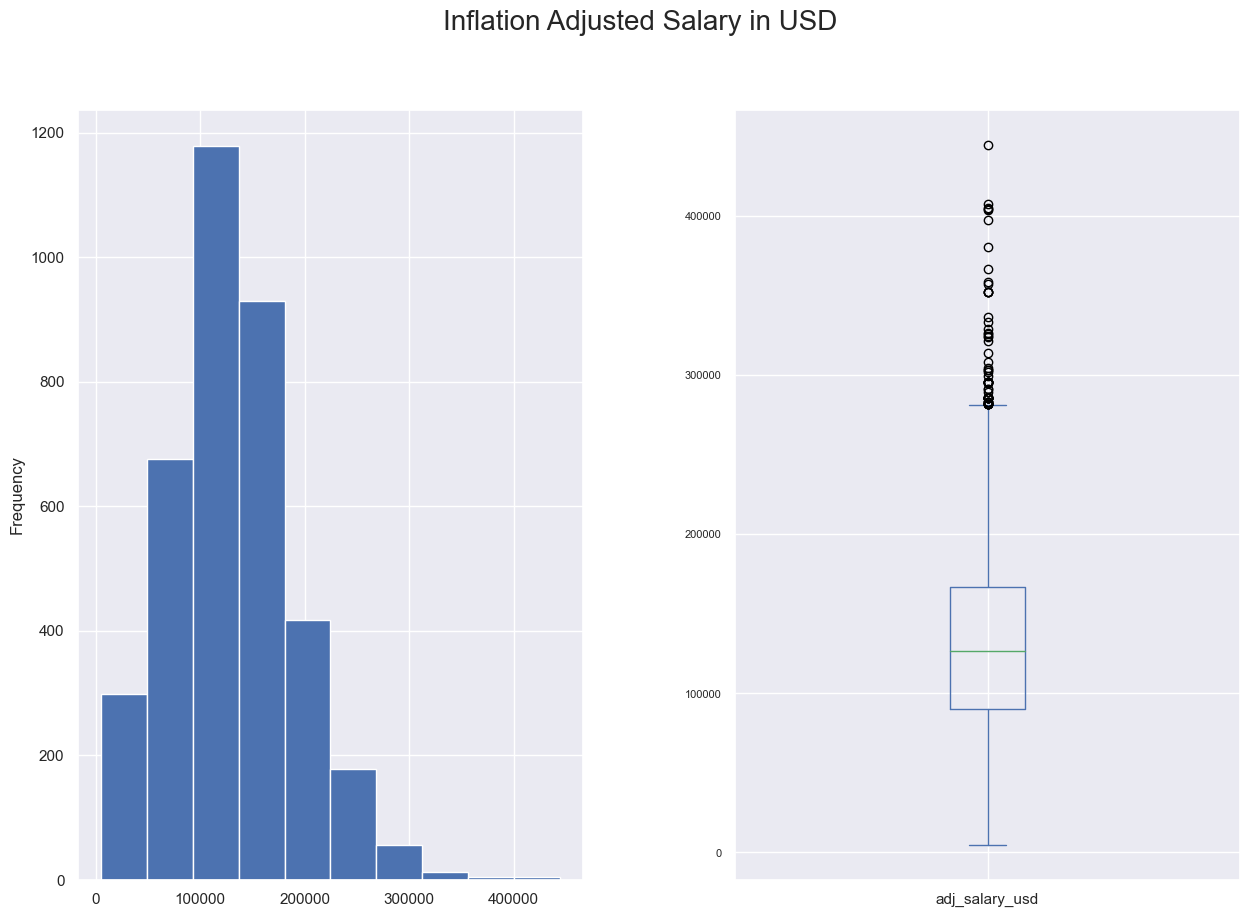

In [134]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,10))

salary_df.adj_salary_usd.plot.hist(ax=ax1)
salary_df.adj_salary_usd.plot.box(ax=ax2)
#for tick in ax2.get_yticklabels():
#    tick.set_rotation(45)
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=8)
plt.suptitle("Inflation Adjusted Salary in USD",fontsize=20)

plt.subplots_adjust(wspace=0.3)

plt.show()

In [135]:
print(salary_df.adj_salary_usd.skew())
print(salary_df.adj_salary_usd.kurtosis())
print(salary_df.adj_salary_usd.describe())

0.5548650794051957
0.9121662034147797
count      3755.000000
mean     130309.357656
std       59822.007923
min        4819.000000
25%       90031.000000
50%      126761.000000
75%      166667.000000
max      444664.000000
Name: adj_salary_usd, dtype: float64


In [136]:
salary_df.remote_ratio.value_counts()

remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64

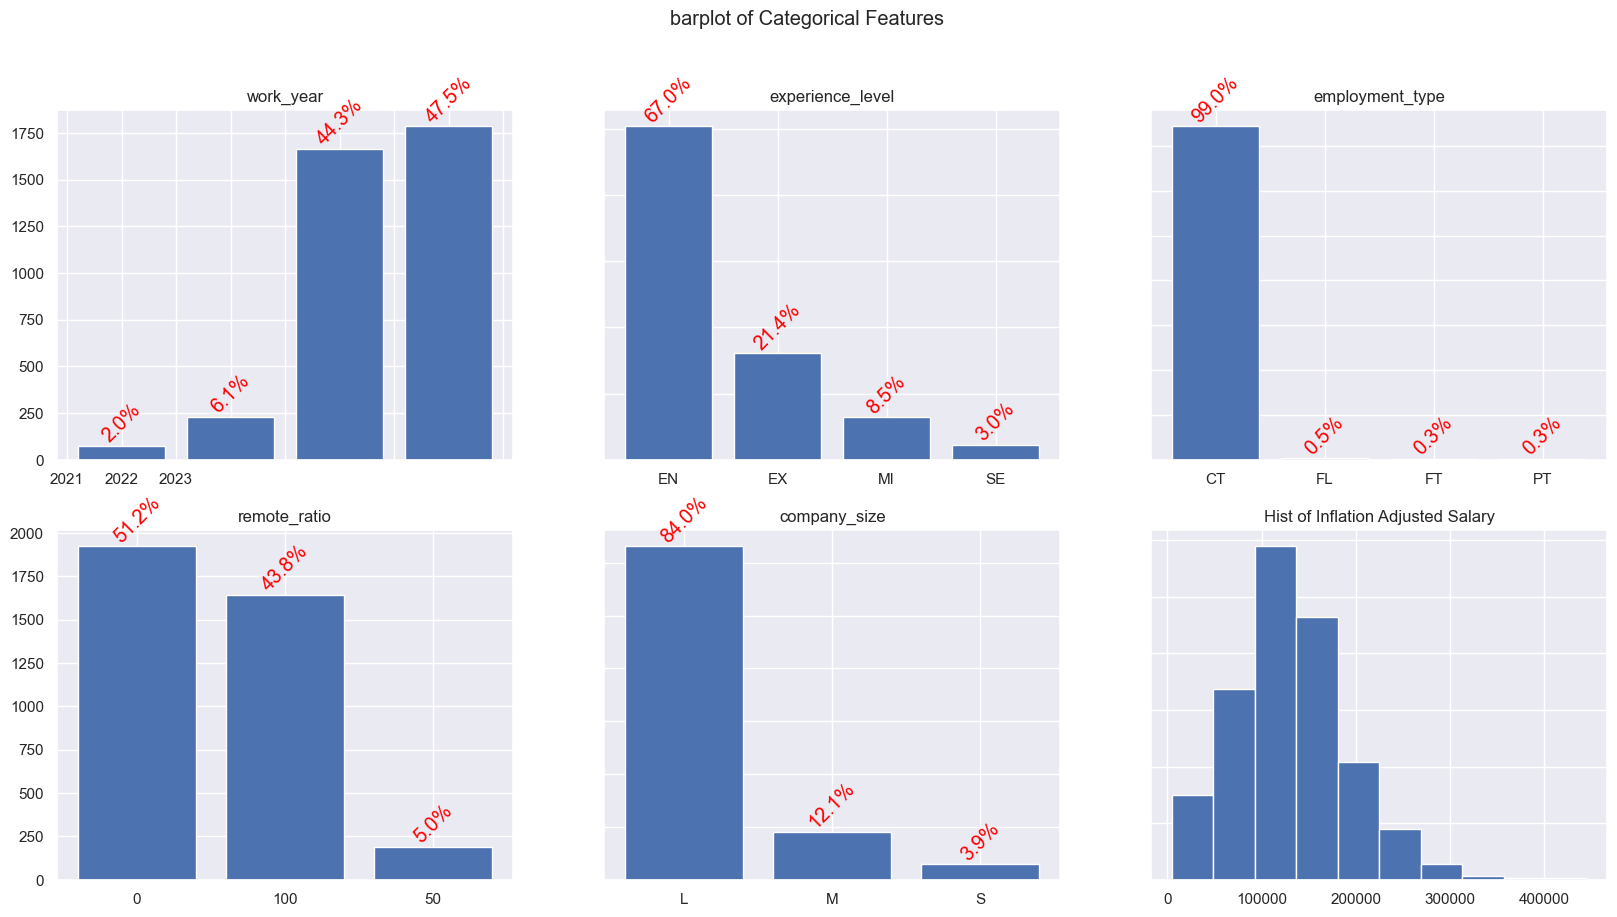

In [137]:
salary_df['remote_ratio_str']=salary_df['remote_ratio'].astype('str')
bar_plot_columns=['work_year','experience_level','employment_type','remote_ratio_str','company_size']

rows, cols =2,3
fig, ax = plt.subplots(rows, cols,figsize=(20,10),squeeze=False)

for row in range(rows):
    for col in range(cols):
        i=row*cols+col
        if i< len(bar_plot_columns):
            ps=salary_df[bar_plot_columns[i]].value_counts()
            bars=ax[row, col].bar(ps.index,ps)
            for bar in bars: 
                height =np.array(round(bar.get_height()/salary_df.shape[0]*100,1))
#                height=np.where(height>1, np.round(height),height)
                ax[row,col].annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), 
                                     xytext=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                     ha='center', va='bottom',fontsize='large',color='red',rotation=45)
            if bar_plot_columns[i]!='remote_ratio_str':
                ax[row, col].set(title=bar_plot_columns[i],xticklabels=ps.sort_index().index)
            if bar_plot_columns[i]=='remote_ratio_str':
                ax[row, col].set(title='remote_ratio',xticklabels=ps.sort_index().index)
            if col>0:
                ax[row, col].set(yticklabels=" ")
        if i>= len(bar_plot_columns):
            salary_df.adj_salary_usd.plot.hist(title="Hist of Inflation Adjusted Salary",ax=ax[row,col])
            ax[row, col].set(yticklabels=" ",ylabel=" ")
plt.suptitle('barplot of Categorical Features')   


#plt.tight_layout(w_pad=2,h_pad=2)
plt.show()



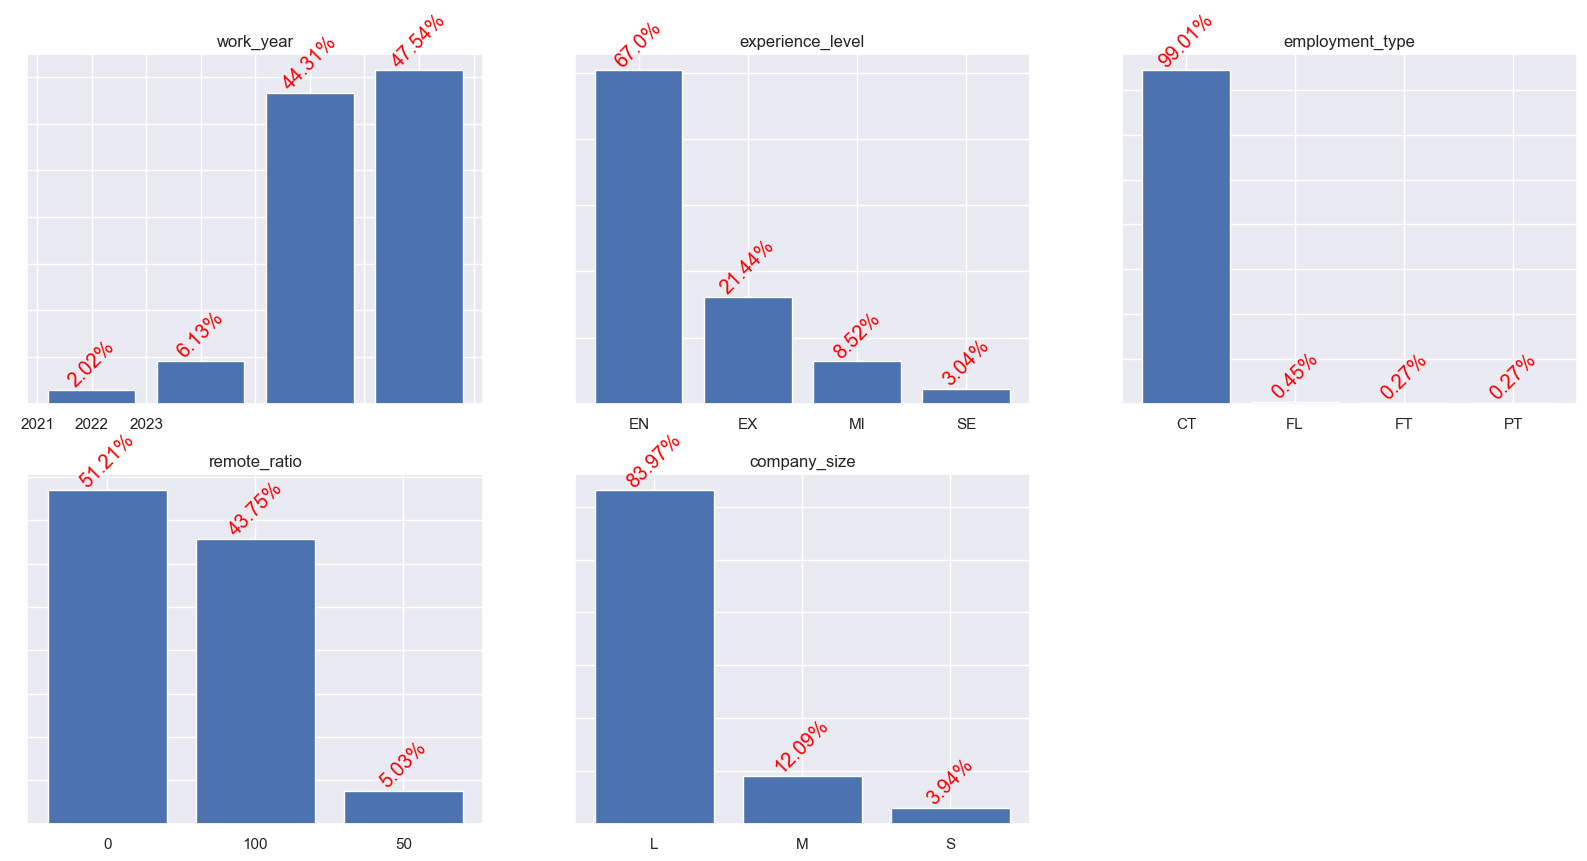

In [138]:
salary_df['remote_ratio_str']=salary_df['remote_ratio'].astype('str')
bar_plot_columns=['work_year','experience_level','employment_type','remote_ratio_str','company_size']

rows, cols =2,3
fig, ax = plt.subplots(rows, cols,figsize=(20,10),squeeze=False)

for row in range(rows):
    for col in range(cols):
        i=row*cols+col
        if i< len(bar_plot_columns):
            ps=salary_df[bar_plot_columns[i]].value_counts()
            bars=ax[row, col].bar(ps.index,ps)
            for bar in bars: 
                height = round(bar.get_height()/salary_df.shape[0]*100,2)
                ax[row,col].annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), 
                                     xytext=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                     ha='center', va='bottom',fontsize='large',color='red',rotation=45)
            if bar_plot_columns[i]!='remote_ratio_str':
                ax[row, col].set(title=bar_plot_columns[i],xticklabels=ps.sort_index().index, yticklabels=" ")
            if bar_plot_columns[i]=='remote_ratio_str':
                ax[row, col].set(title='remote_ratio',xticklabels=ps.sort_index().index, yticklabels=" ")
        if i>= len(bar_plot_columns):
            ax[row, col].axis('off')
            
#plt.suptitle('Distribution of Categorical Features')   


#plt.tight_layout(w_pad=2,h_pad=2)
plt.show()



# 2. EDA

In [139]:
salary_df.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,company_size,employee_region,company_region,adj_salary_usd,remote_ratio_str
0,2023,SE,FT,others,100,L,Europe,Europe,81759.0,100
1,2023,MI,CT,others,100,S,Americas,Americas,28571.0,100
2,2023,MI,CT,others,100,S,Americas,Americas,24286.0,100
3,2023,SE,FT,Data Scientist,100,M,Americas,Americas,166667.0,100
4,2023,SE,FT,Data Scientist,100,M,Americas,Americas,114286.0,100


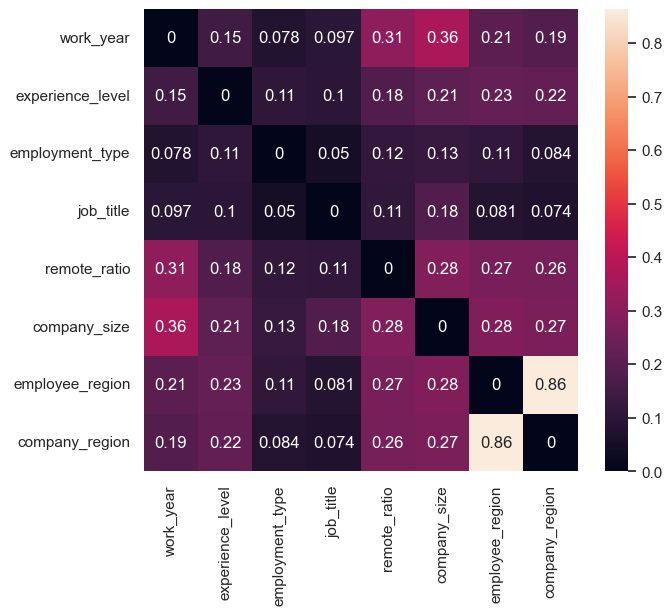

In [140]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols=['work_year','experience_level','employment_type','job_title',
      'remote_ratio','company_size','employee_region','company_region']

corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(salary_df[col1], salary_df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); 
#ax.set_title("Cramer V Correlation Heatmaps between Categorical Variables\n\n", fontsize=15);

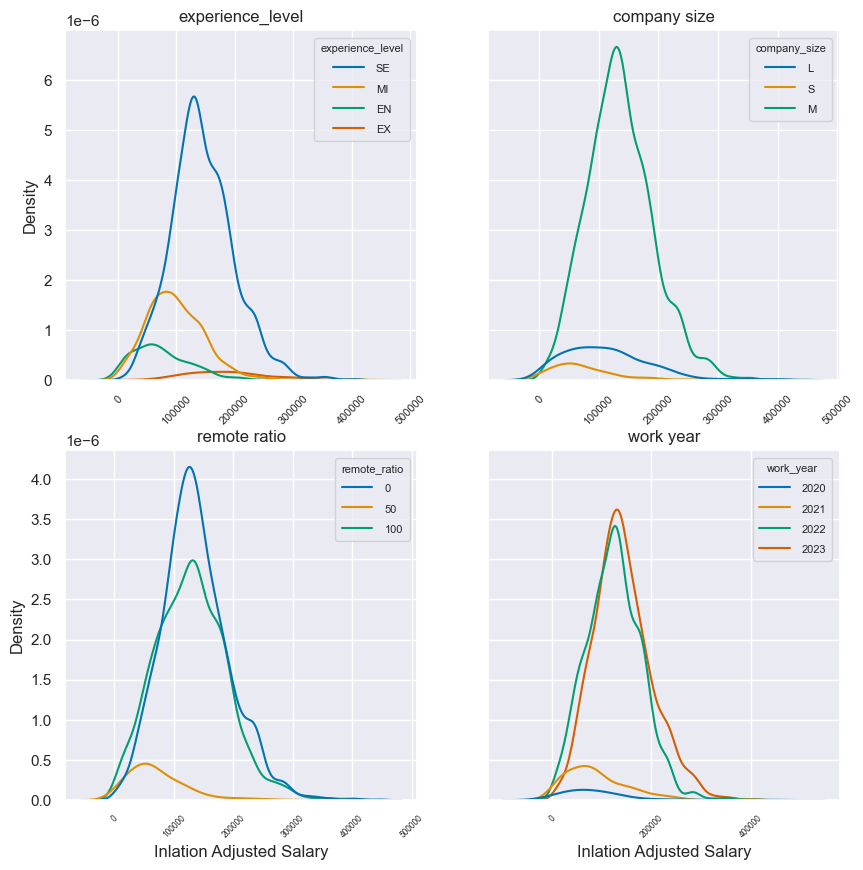

<Figure size 640x480 with 0 Axes>

In [141]:
fig,axes=plt.subplots(2,2,sharey='row',figsize=(10,10))

g00=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="experience_level",ax=axes[0,0],palette='colorblind')
g00.set(xlabel=" ",title='experience_level')
# for legend text
plt.setp(g00.get_legend().get_texts(), fontsize='8')
# for legend title
plt.setp(g00.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g00.get_xticklabels(), fontsize='8',rotation=45)


g01=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="company_size",ax=axes[0,1],palette='colorblind')
g01.set(ylabel=" ",xlabel=" ",title="company size")
# for legend text
plt.setp(g01.get_legend().get_texts(), fontsize='8') 
 # for legend title
plt.setp(g01.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g01.get_xticklabels(), fontsize='8',rotation=45)


g10=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="remote_ratio",ax=axes[1,0],palette='colorblind')
g10.set(xlabel="Inlation Adjusted Salary",title="remote ratio")
#for legend text
plt.setp(g10.get_legend().get_texts(), fontsize='8') 
 # for legend title
plt.setp(g10.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g10.get_xticklabels(), fontsize='6',rotation=45)


g11=sns.kdeplot(data=salary_df, x="adj_salary_usd", hue="work_year",ax=axes[1,1],palette='colorblind')
g11.set(ylabel=" ",xlabel="Inlation Adjusted Salary",title="work year")
# for legend title
plt.setp(g11.get_legend().get_texts(), fontsize='8') 
 # for legend title
plt.setp(g11.get_legend().get_title(), fontsize='8') 
#for xticklabels
plt.setp(g11.get_xticklabels(), fontsize='6',rotation=45)


#plt.suptitle("Distribution of Salary by Features")
plt.show()

plt.savefig('Distribution of Salary by Features',dpi=100)

In [142]:
salary_df.company_region.value_counts()

company_region
Americas    3168
Europe       458
Asia          97
Oceania       18
Africa        14
Name: count, dtype: int64

Text(-17.305555555555557, 0.5, '')

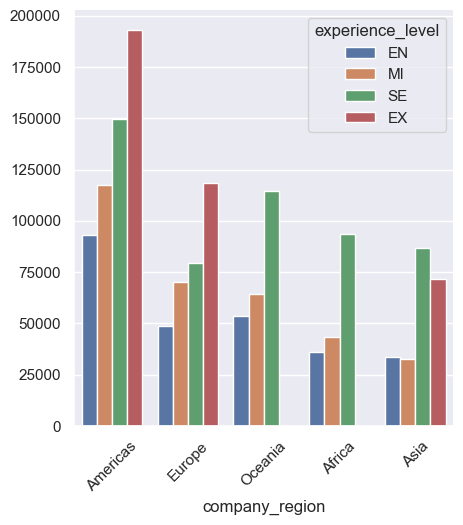

In [143]:
sns.catplot(data=salary_df,x="company_region",y="adj_salary_usd", hue="experience_level",kind='bar',hue_order=['EN','MI','SE','EX'],
            ci=None,legend_out=False, order=['Americas', 'Europe','Oceania','Africa','Asia'])
plt.xticks(rotation=45)
plt.ylabel('')
#plt.title('Distrbution of Adjusted Salary by Company Region')


([], [])

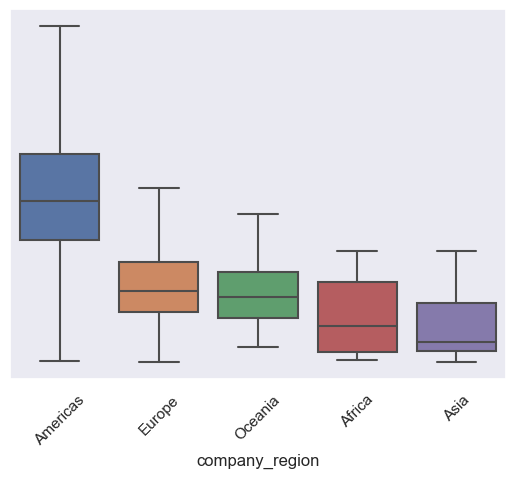

In [144]:
agg_df=salary_df.groupby('company_region')['adj_salary_usd'].agg('median').sort_values(ascending=False)
sns.boxplot(data=salary_df, y="adj_salary_usd", x="company_region",sym='',order=list(agg_df.index))
plt.ylabel('')
plt.xticks(rotation=45)
plt.yticks([])

In [145]:
(salary_df['employee_region']!=salary_df['company_region']).sum()

58

In [146]:
count=(salary_df['employee_region']!=salary_df['company_region']).sum()
perc=round((salary_df['employee_region']!=salary_df['company_region']).sum()/3755*100,2)

print("Occurances of 'Employee Region' and 'Company Region' are not the same is {}= {}%".format(count,perc))
print("Occurances of 'Employee Region' and 'Company Region' are the same is {}= {}%".format(3755-count,100-perc))
print("Cramer's V correlation between 'Employee Region' and 'Company Region' is 0.86")


pd.crosstab(index=salary_df['employee_region'],columns=salary_df['company_region'])

Occurances of 'Employee Region' and 'Company Region' are not the same is 58= 1.54%
Occurances of 'Employee Region' and 'Company Region' are the same is 3697= 98.46%
Cramer's V correlation between 'Employee Region' and 'Company Region' is 0.86


company_region,Africa,Americas,Asia,Europe,Oceania
employee_region,,,,,
Africa,14,1,0,1,1
Americas,0,3135,0,4,1
Asia,0,14,93,8,5
Europe,0,17,3,444,0
Oceania,0,1,1,1,11


In [147]:
##now drop features 'employment_type','employee_region'

salary_df.drop(['employment_type','employee_region'],axis=1,inplace=True)
salary_df.head()

,work_year,experience_level,job_title,remote_ratio,company_size,company_region,adj_salary_usd,remote_ratio_str
0,2023,SE,others,100,L,Europe,81759.0,100
1,2023,MI,others,100,S,Americas,28571.0,100
2,2023,MI,others,100,S,Americas,24286.0,100
3,2023,SE,Data Scientist,100,M,Americas,166667.0,100
4,2023,SE,Data Scientist,100,M,Americas,114286.0,100


In [148]:
salary_df.to_csv('salary_cleaned.csv')

# 3. Pre-Processing

In [149]:
salary_df= pd.read_csv('salary_cleaned.csv', index_col=0)
salary_df.head()

,work_year,experience_level,job_title,remote_ratio,company_size,company_region,adj_salary_usd,remote_ratio_str
0,2023,SE,others,100,L,Europe,81759.0,100
1,2023,MI,others,100,S,Americas,28571.0,100
2,2023,MI,others,100,S,Americas,24286.0,100
3,2023,SE,Data Scientist,100,M,Americas,166667.0,100
4,2023,SE,Data Scientist,100,M,Americas,114286.0,100


In [150]:
for feature in salary_df.columns:
    if len(salary_df[feature].value_counts())<15:
        print(salary_df[feature].value_counts())
print(salary_df.nunique())

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64
job_title
Data Engineer                1040
others                        871
Data Scientist                840
Data Analyst                  612
Machine Learning Engineer     289
Analytics Engineer            103
Name: count, dtype: int64
remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64
company_size
M    3153
L     454
S     148
Name: count, dtype: int64
company_region
Americas    3168
Europe       458
Asia          97
Oceania       18
Africa        14
Name: count, dtype: int64
remote_ratio_str
0      1923
100    1643
50      189
Name: count, dtype: int64
work_year              4
experience_level       4
job_title              6
remote_ratio           3
company_size           3
company_region         5
adj_salary_usd      1272
remote_ratio_str       3
dtype: int64


In [151]:
maplist_oe = [{'col': 'experience_level','mapping': {'EN': 0, 'MI': 1,'SE':2,'EX':3}},\
              {'col': 'work_year','mapping': {'2020':0, '2021': 1,'2022': 2,'2023':3}},\
              {'col': 'company_size', 'mapping':{'S': 0, 'M': 1,'L':2}}]
enc_oe = OrdinalEncoder(mapping=maplist_oe)
salary_df=enc_oe.fit_transform(salary_df)

print(salary_df.shape)

(3755, 8)


In [152]:
columns_be=['remote_ratio','company_region','job_title']            
salary_df = pd.get_dummies(salary_df,columns=columns_be,drop_first=True,dtype=float)
#salary_df.head()

In [153]:
salary_df.head()

,work_year,experience_level,company_size,adj_salary_usd,remote_ratio_str,remote_ratio_50,remote_ratio_100,company_region_Americas,company_region_Asia,company_region_Europe,company_region_Oceania,job_title_Data Analyst,job_title_Data Engineer,job_title_Data Scientist,job_title_Machine Learning Engineer,job_title_others
0,-1.0,2,2,81759.0,100,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.0,1,0,28571.0,100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.0,1,0,24286.0,100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.0,2,1,166667.0,100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.0,2,1,114286.0,100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 4. Training

In [154]:
X=salary_df.drop('adj_salary_usd',axis=1)
y=salary_df.iloc[:,3]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=47)
print('X_train : ',X_train.shape)
print('X_test : ',X_test.shape)

X_train :  (2816, 15)
X_test :  (939, 15)


In [155]:
def adj_r2(X,y, r2_score):
    adj_r2=1-(1-r2_score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    return adj_r2

In [156]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
param_grid = {'n_estimators': n_est,
              'max_depth': np.arange(3, 13)}

regressor=RandomForestRegressor(random_state=47)
               

In [157]:
from sklearn.model_selection import GridSearchCV 

grid = GridSearchCV(regressor, param_grid, cv=5, n_jobs=-1) 
grid.fit(X_train, y_train) 
r2_score = grid.score(X_test,y_test)
adj_r2_score = adj_r2(X_test,y_test, r2_score)
y_pred=grid.predict(X_test)

print("GridsearchCV best parameters : \n\t{}".format(grid.best_params_))
print("GridsearchCV R-squared:{:.3f}".format(r2_score))
print("GridsearchCV Adjusted R-squared:{:.3f}".format(adj_r2_score))

GridsearchCV best parameters : 
	{'max_depth': 5, 'n_estimators': 88}
GridsearchCV R-squared:0.379
GridsearchCV Adjusted R-squared:0.368


work_year                              0.000000
company_region_Oceania                 0.001557
job_title_Data Scientist               0.002260
remote_ratio_50                        0.005097
job_title_Data Engineer                0.006529
remote_ratio_100                       0.007206
company_region_Asia                    0.009433
company_region_Europe                  0.010697
company_size                           0.012242
job_title_Machine Learning Engineer    0.012450
remote_ratio_str                       0.024012
job_title_others                       0.027668
job_title_Data Analyst                 0.091012
experience_level                       0.250478
company_region_Americas                0.539358
dtype: float64


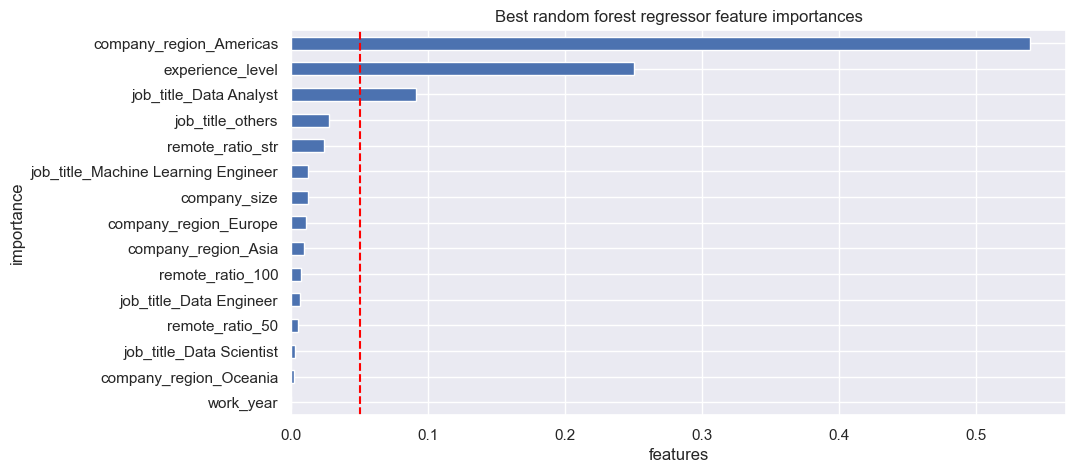

In [161]:
#Plot  feature importances

plt.subplots(figsize=(10, 5))
imps = grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=True)
print(rf_feat_imps)
rf_feat_imps.plot(kind='barh')
plt.xlabel('features')
plt.ylabel('importance')
plt.axvline(0.05,color='red', linestyle='--')
#plt.arrow(x=0, y=0, dx=W, dy=H, **arrow_style)
#plt.text(x=W/2+offsetX, y=H/2, s="U")
plt.title('Best random forest regressor feature importances');

# 5. Modeling

In [233]:
salary_df.columns

Index(['work_year', 'experience_level', 'company_size', 'adj_salary_usd',
       'remote_ratio_str', 'remote_ratio_50', 'remote_ratio_100',
       'company_region_Americas', 'company_region_Asia',
       'company_region_Europe', 'company_region_Oceania',
       'job_title_Data Analyst', 'job_title_Data Engineer',
       'job_title_Data Scientist', 'job_title_Machine Learning Engineer',
       'job_title_others'],
      dtype='object')

In [234]:
X=salary_df[['experience_level','company_region_Americas', 'job_title_Data Analyst']]
y=salary_df.iloc[:,3]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=47)
print('X_train : ',X_train.shape)
print('X_test : ',X_test.shape)

X_train :  (2816, 3)
X_test :  (939, 3)


In [ ]:
grid.fit(X_train, y_train) 
r2_score = grid.score(X_test,y_test)
adj_r2_score = adj_r2(X_test,y_test, r2_score)
y_pred=grid.predict(X_test)

print("GridsearchCV best parameters : \n\t{}".format(grid.best_params_))
print("GridsearchCV R-squared:{:.3f}".format(r2_score))
print("GridsearchCV Adjusted R-squared:{:.3f}".format(adj_r2_score))

In [216]:
sigma

184571.35273938847

In [229]:
#y_test-y_pred
std_resd=(y_test-y_pred)/sigma

array([[ -41175.84332693,  -41175.84332693,   -7093.55441549, ...,
          70426.51030411,  -41175.84332693,   49398.4918561 ],
       [  79280.15667307,   79280.15667307,  113362.44558451, ...,
         190882.51030411,   79280.15667307,  169854.4918561 ],
       [ -46400.84332693,  -46400.84332693,  -12318.55441549, ...,
          65201.51030411,  -46400.84332693,   44173.4918561 ],
       ...,
       [-139961.84332693, -139961.84332693, -105879.55441549, ...,
         -28359.48969589, -139961.84332693,  -49387.5081439 ],
       [  74585.15667307,   74585.15667307,  108667.44558451, ...,
         186187.51030411,   74585.15667307,  165159.4918561 ],
       [-114953.84332693, -114953.84332693,  -80871.55441549, ...,
          -3351.48969589, -114953.84332693,  -24379.5081439 ]])

In [231]:
print(len(y_pred))
print(len(std_resd))

939
939


ValueError: x and y must be the same size

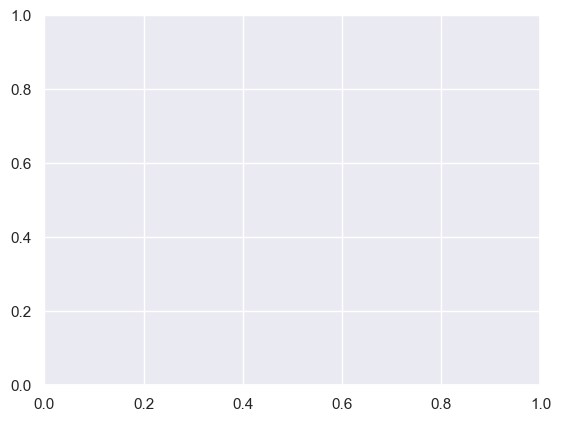

In [232]:
plt.scatter(y_pred,std_resd)
#plt.xticks([])
#plt.yticks([])
plt.ylabel('standardized Residuals')
plt.xlabel('y true')
plt.axhline(y=0)
plt.title('standardized Residual vs Observed',fontsize=20)
#x=linespce 

Text(0.5, 1.0, 'standardized Residual Histogram')

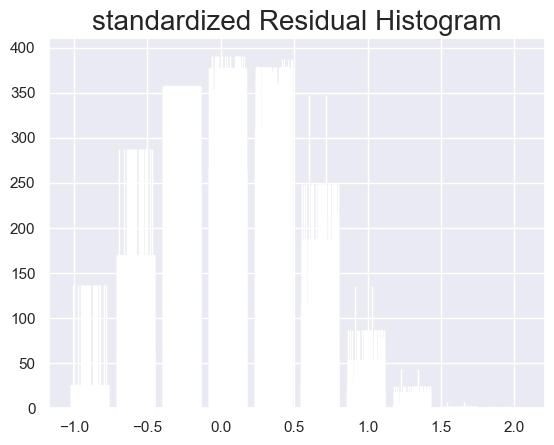

In [225]:
plt.hist(std_resd)
plt.title('standardized Residual Histogram',fontsize=20)